# 지오코딩 결과 시각화 & Matplotlib/Seaborn/Plotly/Altair 종합 예제

이 노트북은 프로젝트에서 생성된 지오코딩 결과(`outputs/주택정비형_geocoded_full.csv`)를 간단히 시각화한 뒤, 다양한 Python 시각화 기법(Matplotlib, Seaborn, Plotly, Altair, ipywidgets 등)을 종합적으로 정리합니다.

구성 개요:
- 지오코딩 포인트 지도 (경계/타일 옵션 포함)
- 기본 선/산점/분포/카테고리/시계열/상관/인터랙티브/애니메이션
- 스타일, 폰트(한글), 이중축, 저장, Jupytext 연계

필요 패키지(일부 선택): `pandas`, `numpy`, `matplotlib`, `seaborn`, `plotly`, `altair`, `ipywidgets`, `geopandas`, `contextily`

## 지오코딩 결과 간단 확인 및 포인트 시각화
가벼운 형태로 `outputs/주택정비형_geocoded.csv` 를 읽고 좌표 산점도를 그립니다. (열: lat, lon, success)

총 행: 153, 유효 좌표 행: 153
위도 범위: (np.float64(37.4507049), np.float64(37.6826056))
경도 범위: (np.float64(126.83692), np.float64(127.15167))


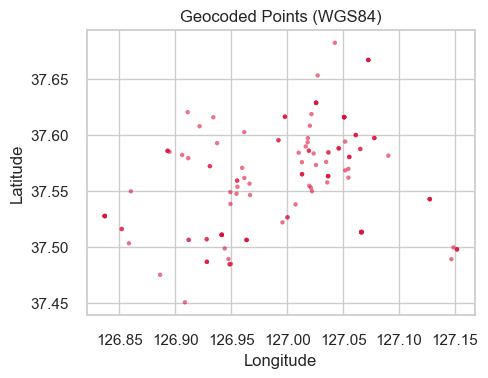

In [17]:
# CSV 경로
csv_path = '/Users/cho/Documents/GitHub/Urban-Refurbishing-Project_DATA-SET/outputs/주택정비형_geocoded.csv'

import pandas as pd, matplotlib.pyplot as plt
try:
    df_geo = pd.read_csv(csv_path)
except FileNotFoundError:
    raise SystemExit(f'파일을 찾을 수 없습니다: {csv_path}')

# 필수 컬럼 존재 확인
required = {'lat','lon'}
missing = required - set(df_geo.columns)
if missing:
    raise SystemExit(f'필수 컬럼 누락: {missing}')

# 좌표 유효 행 필터
pts = df_geo[df_geo['lat'].notna() & df_geo['lon'].notna()].copy()
print(f'총 행: {len(df_geo)}, 유효 좌표 행: {len(pts)}')

# 간단 통계
print('위도 범위:', (pts['lat'].min(), pts['lat'].max()))
print('경도 범위:', (pts['lon'].min(), pts['lon'].max()))

# 산점도
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pts['lon'], pts['lat'], s=10, alpha=0.6, color='crimson', edgecolors='none')
ax.set_title('Geocoded Points (WGS84)')
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.set_aspect('equal', adjustable='box')
plt.show()

### 행정동 경계 Shapefile 로드 및 서울특별시 경계 플롯
`DATA/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp` 파일을 읽어 컬럼 패턴을 탐색하고, '서울특별시' 관련 행만 추출 후 경계를 표시합니다.

필터 로직 순서(존재하는 첫 컬럼 사용): `['SIDO','SIDO_NM','CTP_KOR_NM','광역시도명','SIG_KOR_NM']` 중 '서울' 포함 여부. 실패 시 전체에서 '서울' 패턴을 포함하는 모든 문자열 컬럼 검색.

In [ ]:
# 서울 행정동 공식/사용 이름 세트 정의
SEOUL_DONG_NAMES = {
    '사직동','삼청동','부암동','평창동','무악동','교남동','가회동','종로1·2·3·4가동','종로5·6가동','이화동','창신1동','창신2동','창신3동','숭인1동','숭인2동','청운효자동','혜화동',
    '소공동','회현동','명동','필동','장충동','광희동','을지로동','신당5동','황학동','중림동','신당동','다산동','약수동','청구동','동화동',
    '후암동','용산2가동','남영동','원효로2동','효창동','용문동','이촌1동','이촌2동','이태원1동','이태원2동','서빙고동','보광동','청파동','원효로1동','한강로동','한남동',
    '왕십리2동','마장동','사근동','행당1동','행당2동','응봉동','금호1가동','금호4가동','성수1가1동','성수1가2동','성수2가1동','성수2가3동','송정동','용답동','왕십리도선동','금호2·3가동',
    '옥수동','화양동','군자동','중곡1동','중곡2동','중곡3동','중곡4동','능동','구의1동','구의2동','구의3동','광장동','자양1동','자양2동','자양3동','자양4동',
    '회기동','휘경1동','휘경2동','청량리동','용신동','제기동','전농1동','전농2동','답십리2동','장안1동','장안2동','이문1동','이문2동','답십리1동','면목2동','면목4동','면목5동','면목7동','상봉1동','상봉2동','중화1동','중화2동','묵1동','묵2동','망우3동','신내1동','신내2동','면목본동','면목3·8동','망우본동',
    '돈암1동','돈암2동','안암동','보문동','정릉1동','정릉2동','정릉3동','정릉4동','길음1동','길음2동','월곡1동','월곡2동','장위1동','장위2동','장위3동','성북동','삼선동','동선동','종암동','석관동',
    '번1동','번2동','번3동','수유1동','수유2동','수유3동','삼양동','미아동','송중동','송천동','삼각산동','우이동','인수동','쌍문1동','쌍문2동','쌍문3동','쌍문4동','방학1동','방학2동','방학3동','창1동','창2동','창3동','창4동','창5동','도봉1동','도봉2동',
    '월계1동','월계2동','월계3동','공릉2동','하계1동','하계2동','중계본동','중계1동','중계4동','상계1동','상계2동','상계5동','상계8동','상계9동','상계10동','상계3·4동','상계6·7동','중계2·3동','공릉1동',
    '녹번동','불광1동','갈현1동','갈현2동','구산동','대조동','응암1동','응암2동','신사1동','신사2동','증산동','수색동','진관동','불광2동','응암3동','역촌동',
    '천연동','홍제1동','홍제3동','홍제2동','홍은1동','홍은2동','남가좌1동','남가좌2동','북가좌1동','북가좌2동','충현동','북아현동','신촌동','연희동',
    '용강동','대흥동','염리동','신수동','서교동','합정동','망원1동','망원2동','연남동','성산1동','성산2동','상암동','도화동','서강동','공덕동','아현동',
    '목1동','목2동','목3동','목4동','신월1동','신월2동','신월3동','신월4동','신월5동','신월6동','신월7동','신정1동','신정2동','신정3동','신정6동','신정7동','목5동','신정4동',
    '염창동','등촌1동','등촌2동','등촌3동','화곡본동','화곡2동','화곡3동','화곡4동','화곡6동','화곡8동','가양2동','가양3동','발산1동','공항동','방화1동','방화2동','화곡1동','우장산동','가양1동','방화3동',
    '신도림동','구로1동','구로3동','구로4동','구로5동','고척1동','고척2동','개봉2동','개봉3동','오류1동','수궁동','가리봉동','구로2동','개봉1동','오류2동','항동',
    '가산동','독산1동','독산2동','독산3동','독산4동','시흥1동','시흥2동','시흥3동','시흥4동','시흥5동',
    '여의동','당산1동','당산2동','양평1동','양평2동','신길1동','신길3동','신길4동','신길5동','신길6동','신길7동','대림1동','대림2동','대림3동','영등포본동','영등포동','도림동','문래동',
    '노량진2동','상도1동','상도2동','상도3동','상도4동','사당1동','사당3동','사당4동','사당5동','대방동','신대방1동','신대방2동','흑석동','노량진1동','사당2동','보라매동','청림동','행운동','낙성대동','중앙동','인헌동','남현동','서원동','신원동','서림동','신사동','신림동','난향동','조원동','대학동','은천동','성현동','청룡동','난곡동','삼성동','미성동',
    '서초1동','서초2동','서초3동','서초4동','잠원동','반포본동','반포1동','반포2동','반포3동','반포4동','방배본동','방배1동','방배2동','방배3동','방배4동','양재1동','양재2동','내곡동',
    '개포3동','논현1동','논현2동','삼성1동','삼성2동','대치1동','대치4동','역삼1동','역삼2동','도곡1동','도곡2동','개포1동','개포4동','일원본동','일원1동','수서동','세곡동','압구정동','청담동','대치2동','개포2동','일원2동','일원동','대치3동',
    '풍납1동','풍납2동','거여1동','거여2동','마천1동','마천2동','방이1동','방이2동','오륜동','오금동','송파1동','송파2동','석촌동','삼전동','가락본동','가락1동','가락2동','문정1동','문정2동','잠실본동','잠실4동','잠실6동','잠실7동','잠실2동','잠실3동','장지동','위례동',
    '명일1동','명일2동','고덕1동','고덕2동','암사2동','암사3동','천호1동','천호3동','성내1동','성내2동','성내3동','둔촌1동','둔촌2동','암사1동','천호2동','길동','강일동','상일1동','상일2동'
}
print('[INFO] 서울 행정동 세트 정의 개수:', len(SEOUL_DONG_NAMES))

In [20]:
# 경계 Shapefile 경로
shp_path = '/Users/cho/Documents/GitHub/Urban-Refurbishing-Project_DATA-SET/DATA/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp'

import os
try:
    import geopandas as gpd
except ImportError:
    gpd = None

if gpd is None:
    print('[WARN] geopandas 미설치 - 경계 표시 불가')
else:
    if not os.path.exists(shp_path):
        print(f'[ERROR] Shapefile 경로 없음: {shp_path}')
    else:
        gdf = gpd.read_file(shp_path)
        print('[INFO] 경계 원본 행수:', len(gdf))
        print('[COLUMNS]', list(gdf.columns))

        # 행정동 후보 컬럼: 이름에 DONG 또는 '동' 포함
        dong_col_candidates = [c for c in gdf.columns if any(k in c for k in ['DONG','동'])]
        target_dong_col = None
        for c in dong_col_candidates:
            if gdf[c].dtype == object or str(gdf[c].dtype).startswith('category'):
                target_dong_col = c
                break
        if target_dong_col is None:
            print('[ERROR] 행정동 컬럼을 찾지 못했습니다. dong_col_candidates =', dong_col_candidates)
        else:
            # 동 이름 정규화 함수 (필요 시 확장 가능)
            def norm_name(x:str):
                if x is None:
                    return ''
                x = str(x).strip()
                # 중간 공백/전각 대비 등 최소 정규화 (여기서는 그대로 두지만 후에 패턴 추가 가능)
                return x
            gdf['__DONG_NAME__'] = gdf[target_dong_col].map(norm_name)
            # 우리 세트와 교집합만 필터
            if 'SEOUL_DONG_NAMES' not in globals():
                print('[WARN] SEOUL_DONG_NAMES 세트가 없습니다. 먼저 정의 셀을 실행하세요.')
                gdf_seoul = gdf.copy()
            else:
                mask = gdf['__DONG_NAME__'].isin(SEOUL_DONG_NAMES)
                gdf_seoul = gdf[mask].copy()
            print('[INFO] 필터 후 (세트 기반) 행수:', len(gdf_seoul))

            # 좌표계 (없으면 WGS84 가정)
            if gdf_seoul.crs is None:
                gdf_seoul.set_crs(epsg=4326, inplace=True)
            fig, ax = plt.subplots(figsize=(5,5))
            gdf_seoul.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
            ax.set_title('서울특별시 행정동 경계 (세트 필터 기반)')
            ax.set_axis_off()
            plt.show()

[INFO] 경계 원본 행수: 3558
[COLUMNS] ['BASE_DATE', 'ADM_CD', 'ADM_NM', 'geometry']
[ERROR] 행정동 컬럼을 찾지 못했습니다. dong_col_candidates = []
